In [16]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from google.colab import files
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from tqdm.auto import tqdm
from torchmetrics import MeanAbsolutePercentageError, MeanAbsoluteError
from datetime import datetime  

# Helpers

In [21]:
def scale_data(load_df, 
               start_train_date,
               end_val_date,
               start_test_date,
               end_test_date):
  
  train_val_df = load_df[(load_df.index >= start_train_date) &
                        (load_df.index <= end_val_date)]
  test_df = load_df[(load_df.index >= start_test_date) &
                    (load_df.index <= end_test_date)]

  scaler = MinMaxScaler()
  train_val_scaled = scaler.fit_transform(train_val_df)
  train_val_df_scaled = pd.DataFrame(train_val_scaled,
                                    columns=train_val_df.columns,
                                    index=train_val_df.index)
  test_scaled = scaler.transform(test_df)
  test_df_scaled = pd.DataFrame(test_scaled,
                                columns=test_df.columns,
                                index=test_df.index)

  load_df_scaled = pd.concat([train_val_df_scaled, test_df_scaled], axis=0)

  return load_df_scaled, scaler

In [22]:
def reframing(X_df, Y_df, n_backwards=1, skip_steps_forward=0, n_forwards=1):

  feat_cols, feat_names = [], []
  # iterate through all columns
  for col_index, col_name in enumerate(X_df.columns):
    series = X_df[col_name].copy()
    # input sequence (t, t-1, ... ,t-(n_backwards+1) )
    for b in range(n_backwards):
      feat_cols.append(series.shift(b))
      feat_names.append(f'{col_name}_(t-{b})')
  
  # put it all together
  X = pd.concat(feat_cols, axis=1)
  X.columns = feat_names
  # drop rows with NaN values
  X.dropna(inplace=True)
  X_index = X.index
    
  # forecast sequence (t + SKIP_STEPS_FORWARD + 1, ... , t + n_forwards)
  series = Y_df
  target_cols, target_names = [], []
  for f in range(skip_steps_forward + 1, n_forwards): 
    target_cols.append(Y_df.shift(-f))
    if f == 0:
      target_names.append(f'{Y_df.name}_t')
    else:
      target_names.append(f'{Y_df.name}_(t+{f})')

  # put it all together
  Y = pd.concat(target_cols, axis=1)
  Y.columns = target_names
  # drop rows with NaN values
  Y.dropna(inplace=True)
  Y_index = Y.index
  
  return X, X_index, Y, Y_index

def reframe_data(load_df_scaled, 
                 target,
                 days_back,
                 last_step_forward,
                 last_step_back,
                 skip_steps_forward):

  time_weather_cols = load_df_scaled.drop(TARGET, axis=1).columns

  # shift future values
  for col in time_weather_cols:
    load_df_scaled[col + f'_(t+{LAST_STEP_FORWARD})'] = load_df_scaled[col].shift(-LAST_STEP_FORWARD)
    load_df_scaled.drop(col, axis=1, inplace=True)

  load_df_scaled.dropna(inplace=True)

  X_orig, X_index, Y_orig, Y_index = reframing(load_df_scaled, 
                                                load_df_scaled[TARGET], 
                                                n_backwards=LAST_STEP_BACK,
                                                skip_steps_forward=SKIP_STEPS_FORWARD,
                                                n_forwards=LAST_STEP_FORWARD+1)
  common_index = X_index.intersection(Y_index)
  X_df = X_orig.loc[common_index]
  Y_df = Y_orig.loc[common_index]

  load_df_scaled_reframed = pd.concat([X_df, Y_df], axis=1)

  return load_df_scaled_reframed

In [23]:
def create3Dinput(df, last_step_back):
  N, D = df.shape
  D = int(D/last_step_back)
  arr_3d = np.zeros((N, last_step_back, D))
  for i in range(D):
    arr_3d[:, :, i] = df.iloc[:, i*last_step_back:(i+1)*last_step_back].values
  print(arr_3d.shape)
  return arr_3d


def split_data(load_df_scaled_reframed,
               start_train_date,
               end_train_date,
               start_val_date,
               end_val_date,
               start_test_date,
               end_test_date,
               steps_forward,
               last_step_back):

  load_train_df_scaled_reframed = load_df_scaled_reframed[(load_df_scaled_reframed.index >= start_train_date) & 
                                                          (load_df_scaled_reframed.index <= end_train_date)]

  load_val_df_scaled_reframed = load_df_scaled_reframed[(load_df_scaled_reframed.index >= start_val_date) & 
                                                        (load_df_scaled_reframed.index <= end_val_date)]

  load_test_df_scaled_reframed = load_df_scaled_reframed[(load_df_scaled_reframed.index >= start_test_date) & 
                                                        (load_df_scaled_reframed.index <= end_test_date)]

  load_train_df_scaled_reframed = shuffle(load_train_df_scaled_reframed)    

  X_train_df = load_train_df_scaled_reframed.iloc[:, :-steps_forward]
  y_train_df = load_train_df_scaled_reframed.iloc[:, -steps_forward:]

  X_val_df = load_val_df_scaled_reframed.iloc[:, :-steps_forward]
  y_val_df = load_val_df_scaled_reframed.iloc[:, -steps_forward:]

  X_test_df = load_test_df_scaled_reframed.iloc[:, :-steps_forward]
  y_test_df = load_test_df_scaled_reframed.iloc[:, -steps_forward:]

  X_train_3D = create3Dinput(X_train_df, last_step_back)
  X_val_3D = create3Dinput(X_val_df, last_step_back)
  X_test_3D = create3Dinput(X_test_df, last_step_back)

  return X_train_3D, X_val_3D, X_test_3D, y_train_df, y_val_df, y_test_df

In [24]:
class LoadDataset(Dataset):
  def __init__(self, X_3D, y_df):
    self.X = torch.tensor(X_3D, dtype=torch.float32)
    self.y = torch.tensor(y_df.values, dtype=torch.float32)
  
  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [25]:
class CNN_Dense(nn.Module):
  def __init__(self, 
               input_units,
               output_units):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv1d(in_channels=input_units,
                  out_channels=1024,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv1d(in_channels=1024,
                  out_channels=512,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv1d(in_channels=512,
                  out_channels=256,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU()
    )

    self.flatten = nn.Flatten()

    self.dense_layers = nn.Sequential(
        nn.Linear(in_features=16896,
                  out_features=1024),
        nn.ReLU(),
        nn.Linear(in_features=1024,
                  out_features=512),
        nn.ReLU()
    )

    self.output_layer = nn.Linear(in_features=512,
                                  out_features=output_units)
  
  def forward(self, x):
    x = self.conv_layers(x)
    x = self.flatten(x)
    x = self.dense_layers(x)
    return self.output_layer(x)

In [26]:
def loss_fn(y_preds, y_true, device):
  epsilon = 1.17e-06
  loss = torch.zeros(1, requires_grad=True).to(device)
  abs_diff = torch.abs(y_preds - y_true)
  abs_per_error = abs_diff / torch.clamp(torch.abs(y_true), min=epsilon)
  mape = torch.sum(abs_per_error) / y_true.numel()

  return 100 * mape   #+ 0.5 * torch.max(torch.tensor([[0., mape-2]])) * mape

def train_step(model, dataloader, optimizer, device):
  model.train()
  loss = 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_preds = model(X).squeeze().to(device)
    batch_loss = loss_fn(y_preds, y, device) 
    loss += batch_loss.item()
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
  
  loss /= len(dataloader)
  return loss

def val_step(model, dataloader, device):
  model.eval()
  val_loss = 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      val_preds = model(X).squeeze().to(device)

      y_unscaled = scaler.data_min_[TARGET_POS] + y * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])
      y_preds_unscaled = scaler.data_min_[TARGET_POS] + val_preds * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])

      batch_loss = loss_fn(y_preds_unscaled, y_unscaled, device) 
      val_loss += batch_loss.item()
  
  val_loss /= len(dataloader)
  return val_loss

def train(model, 
          train_dataloader,
          val_dataloader,
          optimizer,
          epochs,
          patience,
          device,
          path):
  
  results = {
      "loss": [],
      "val_loss": []
  }

  for epoch in tqdm(range(epochs)):
    flag = 0
    loss = train_step(model=model,
                      dataloader=train_dataloader,
                      optimizer=optimizer,
                      device=device)

    val_loss = val_step(model=model,
                        dataloader=val_dataloader,
                        device=device)
    
    results['loss'].append(loss)
    results['val_loss'].append(val_loss)
    if epoch == 0:
      best_val_loss = val_loss
      best_epoch = -1
      checkpoint(model, optimizer, path)
      flag = 1
      print(f"Epoch: {epoch} | Loss: {loss:.4f} | Val loss: {val_loss:.4f} - *Checkpoint*")
    else:
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        checkpoint(model, optimizer, path)
        flag = 1
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Val loss: {val_loss:.4f} - *Checkpoint*")
      elif epoch - best_epoch > patience:
        print(f"\nEarly stopping applied at epoch {epoch}.")
        break
    if flag == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f} | Val loss: {val_loss:.4f}")
  
  return results

def checkpoint(model, optimizer, filepath):
  torch.save({
    "optimizer": optimizer.state_dict(),
    "model": model.state_dict()
  }, filepath)

# MAIN

In [27]:
DAYS_BACK = 3
DAYS_TO_SKIP = 10
STEPS_FORWARD = 24    # 1 day
SKIP_STEPS_FORWARD = 24 * DAYS_TO_SKIP
LAST_STEP_FORWARD = STEPS_FORWARD + SKIP_STEPS_FORWARD
LAST_STEP_BACK = 24 * DAYS_BACK

# keep 1 year for testing
START_TEST_DATE = pd.to_datetime('2018-01-01') - pd.to_timedelta(LAST_STEP_FORWARD, 'h')
END_TEST_DATE = START_TEST_DATE + pd.DateOffset(years=1)

END_VAL_DATE = START_TEST_DATE - pd.to_timedelta(1, 'h')
START_VAL_DATE = pd.to_datetime('2017-01-01') - pd.to_timedelta(LAST_STEP_FORWARD, 'h')

# START_TRAIN_DATE = pd.to_datetime('2016-01-01')
START_TRAIN_DATE = pd.to_datetime('2010-10-01')
END_TRAIN_DATE = START_VAL_DATE - pd.to_timedelta(1, 'h')

TARGET = "TOTAL_CONS"
COL_TO_DROP = ['humidity', 'hour', 'weekday', 'dayofyear']

BATCH_SIZE = 1024
EPOCHS = 1000
PATIENCE = 30
PATH = "model.pth"

print(f"Train from {START_TRAIN_DATE} to {END_TRAIN_DATE}")
print(f"Validation from {START_VAL_DATE} to {END_VAL_DATE}")
print(f"Test from {START_TEST_DATE} to {END_TEST_DATE}")

Train from 2010-10-01 00:00:00 to 2016-12-20 23:00:00
Validation from 2016-12-21 00:00:00 to 2017-12-20 23:00:00
Test from 2017-12-21 00:00:00 to 2018-12-21 00:00:00


In [44]:
load_df = pd.read_csv("/content/FINAL_DATASET_2.csv")
load_df.set_index(pd.to_datetime(load_df["Timestamp"]), inplace=True)
load_df.drop("Timestamp", axis=1, inplace=True)
# load_df.drop(COL_TO_DROP, axis=1, inplace=True)

FUTR_COLS = load_df.drop(TARGET, axis=1).columns
TARGET_POS = np.where(load_df.columns == TARGET)[0][0]

load_df.columns

Index(['TOTAL_CONS', 'Weekend', 'Holiday', 'temp', 'humidity', 'hour',
       'weekday', 'dayofyear'],
      dtype='object')

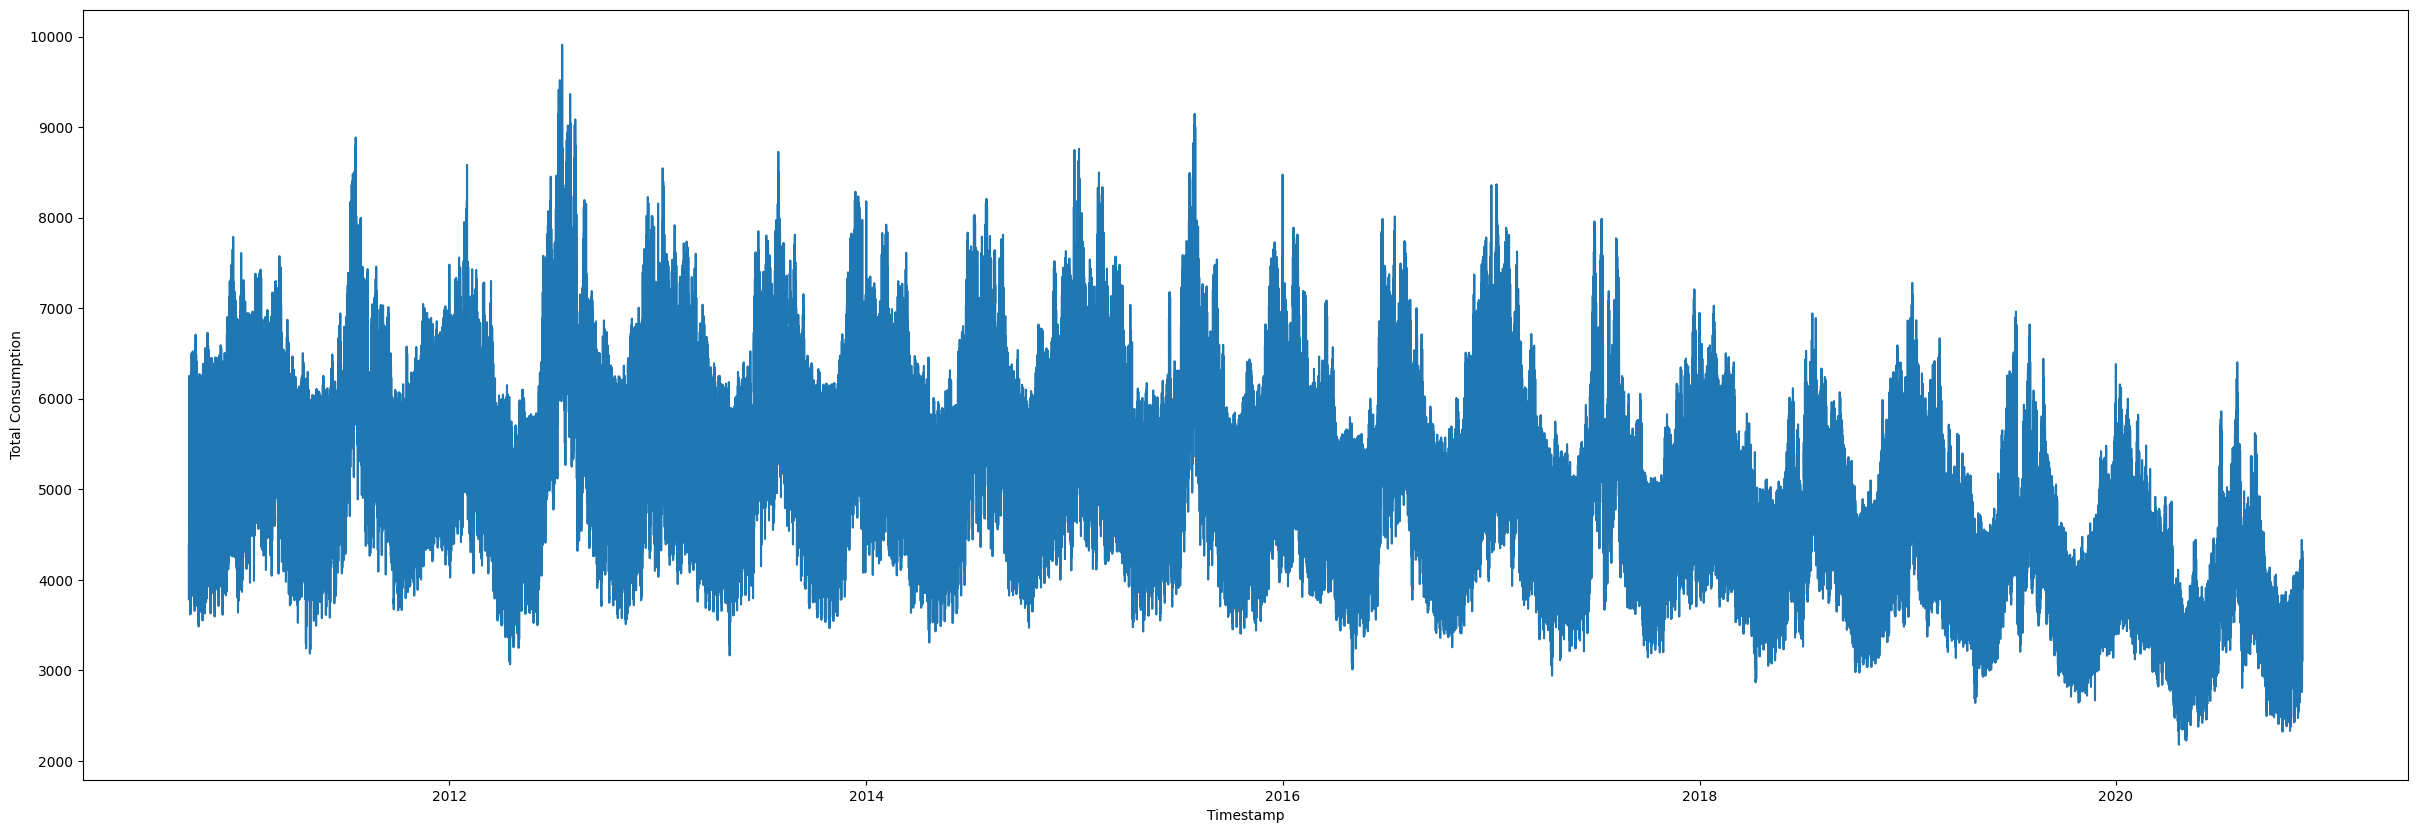

In [41]:
plt.figure(figsize=(30, 10))
plt.plot(load_df.index.values, load_df[TARGET].values)
plt.xlabel("Timestamp")
plt.ylabel("Total Consumption")
plt.show()

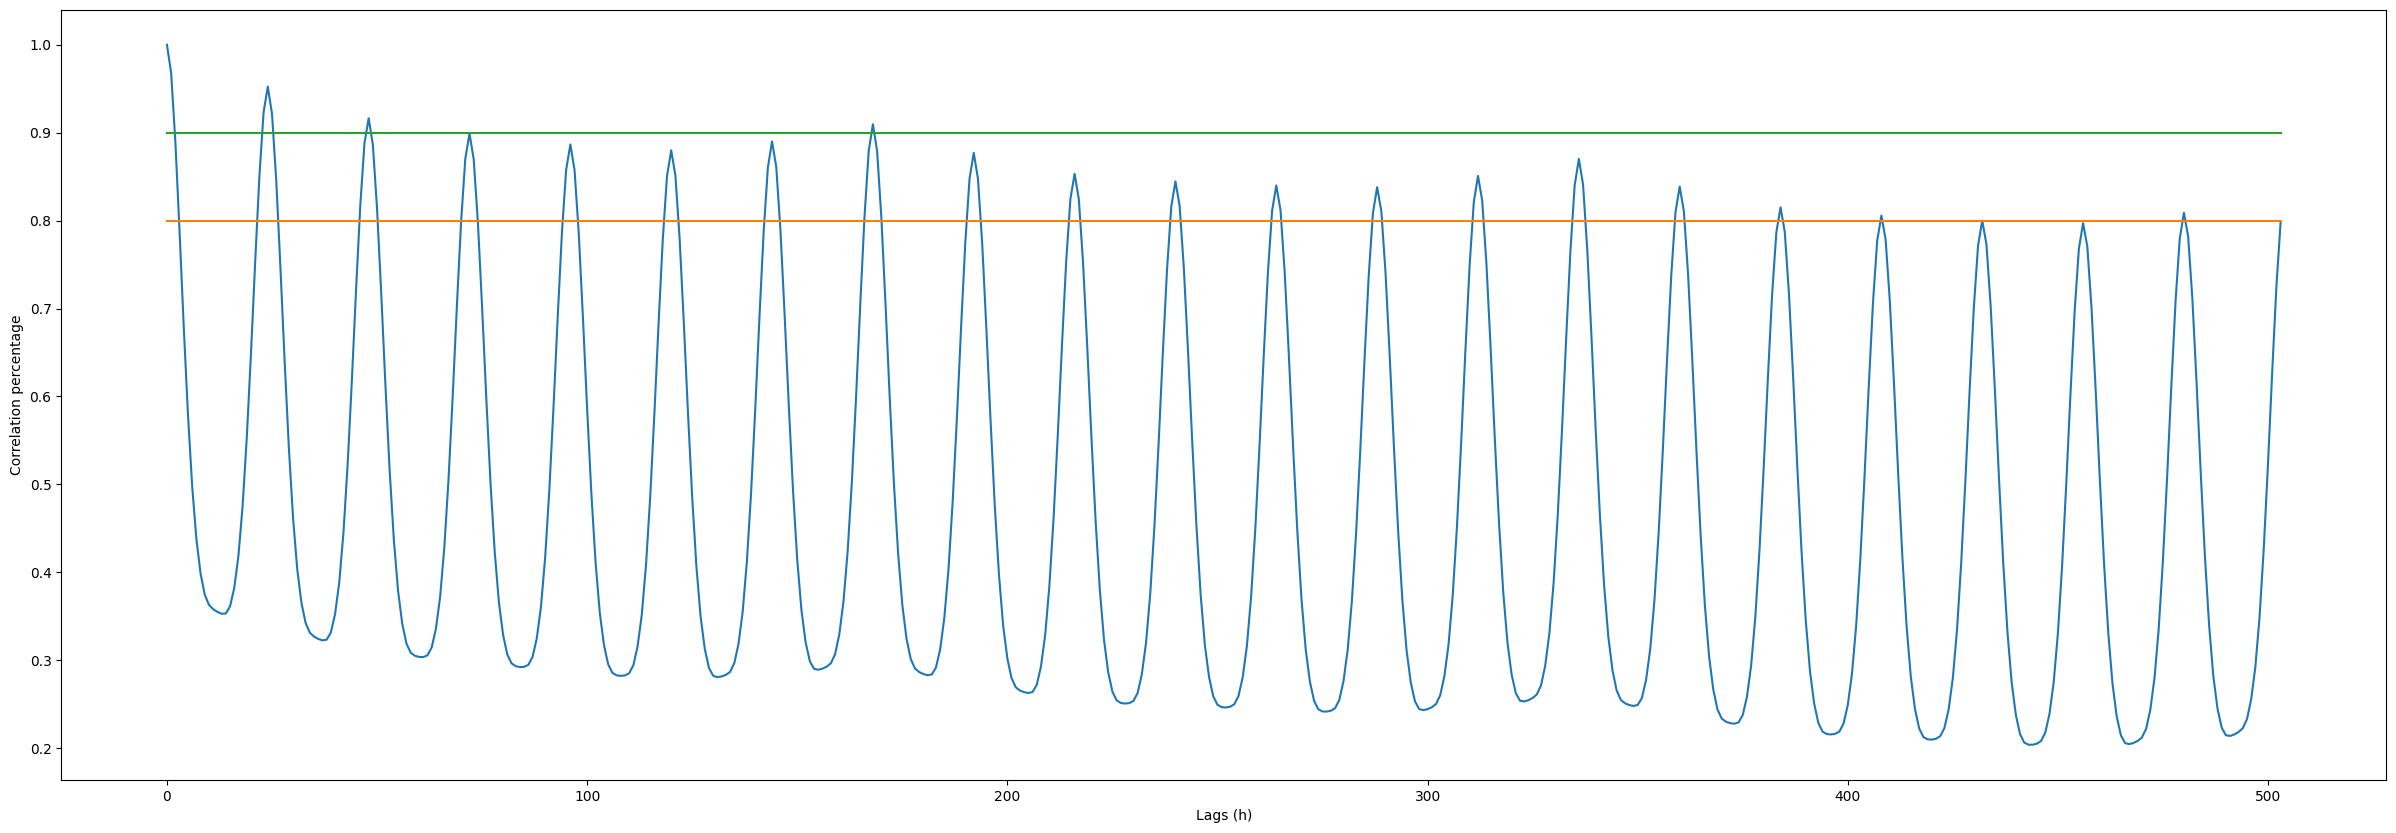

In [43]:
autocorr_list = []
days = 21
lags = 24 * days
for lag in range(lags):
  autocorr_list.append(load_df["TOTAL_CONS"].autocorr(lag=lag))

autocorr = np.array(autocorr_list)
plt.figure(figsize=(30, 10))
plt.plot(autocorr)
plt.plot(0.8 * np.ones(lags))
plt.plot(0.9 * np.ones(lags))
plt.xlabel("Lags (h)")
plt.ylabel("Correlation percentage")
plt.show()

In [45]:
corr = load_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,TOTAL_CONS,Weekend,Holiday,temp,humidity,hour,weekday,dayofyear
TOTAL_CONS,1.000000,-0.113112,-0.096831,0.208971,-0.340089,0.465101,-0.086178,-0.052847
Weekend,-0.113112,1.000000,0.018321,0.004864,0.015178,0.000000,0.790601,0.001976
Holiday,-0.096831,0.018321,1.000000,-0.076725,0.002682,0.000000,-0.009465,-0.036804
temp,0.208971,0.004864,-0.076725,1.000000,-0.349898,0.241087,-0.000843,0.263483
humidity,-0.340089,0.015178,0.002682,-0.349898,1.000000,-0.267018,0.009912,-0.020797
hour,0.465101,0.000000,0.000000,0.241087,-0.267018,1.000000,-0.000000,0.000000
weekday,-0.086178,0.790601,-0.009465,-0.000843,0.009912,-0.000000,1.000000,0.001423
dayofyear,-0.052847,0.001976,-0.036804,0.263483,-0.020797,0.000000,0.001423,1.000000


In [29]:
load_df_scaled, scaler = scale_data(load_df,
                                    START_TRAIN_DATE,
                                    END_VAL_DATE,
                                    START_TEST_DATE,
                                    END_TEST_DATE)

load_df_scaled_reframed = reframe_data(load_df_scaled, 
                                       TARGET,
                                       DAYS_BACK,
                                       LAST_STEP_FORWARD,
                                       LAST_STEP_BACK,
                                       SKIP_STEPS_FORWARD)

X_train_3D, X_val_3D, X_test_3D, y_train_df, y_val_df, y_test_df = split_data(load_df_scaled_reframed,
                                                                              START_TRAIN_DATE,
                                                                              END_TRAIN_DATE,
                                                                              START_VAL_DATE,
                                                                              END_VAL_DATE,
                                                                              START_TEST_DATE,
                                                                              END_TEST_DATE,
                                                                              STEPS_FORWARD,
                                                                              LAST_STEP_BACK)

X_train_3D = np.transpose(X_train_3D, (0, 2, 1))
X_val_3D = np.transpose(X_val_3D, (0, 2, 1))
X_test_3D = np.transpose(X_test_3D, (0, 2, 1))
print(X_train_3D.shape)

(54481, 72, 4)
(8760, 72, 4)
(8233, 72, 4)
(54481, 4, 72)


In [30]:
train_dataset = LoadDataset(X_3D=X_train_3D, 
                            y_df=y_train_df)
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataset = LoadDataset(X_3D=X_val_3D,
                          y_df=y_val_df)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE)

test_dataset = LoadDataset(X_3D=X_test_3D,
                           y_df=y_test_df)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE)

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
model = CNN_Dense(input_units=X_train_3D.shape[1],
                  output_units=24).to(device)
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3)

In [33]:
!rm -rf "model.pth"
start_time = datetime.now()

model_results = train(model=model, 
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      epochs=EPOCHS,
                      patience=PATIENCE,
                      device=device,
                      path=PATH)

total_time = datetime.now() - start_time
print(f"Total training time: {total_time.seconds}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 | Loss: 43.0616 | Val loss: 9.2830 - *Checkpoint*
Epoch: 1 | Loss: 16.7358 | Val loss: 6.8126 - *Checkpoint*
Epoch: 2 | Loss: 14.2534 | Val loss: 8.1205
Epoch: 3 | Loss: 13.3165 | Val loss: 8.2905
Epoch: 4 | Loss: 12.4727 | Val loss: 8.8678
Epoch: 5 | Loss: 11.9214 | Val loss: 5.9783 - *Checkpoint*
Epoch: 6 | Loss: 11.7386 | Val loss: 7.3708
Epoch: 7 | Loss: 11.2621 | Val loss: 7.2530
Epoch: 8 | Loss: 11.0622 | Val loss: 6.5705
Epoch: 9 | Loss: 10.8494 | Val loss: 7.1433
Epoch: 10 | Loss: 11.2730 | Val loss: 7.6392
Epoch: 11 | Loss: 10.3722 | Val loss: 5.6565 - *Checkpoint*
Epoch: 12 | Loss: 10.6061 | Val loss: 6.8695
Epoch: 13 | Loss: 10.3415 | Val loss: 6.3747
Epoch: 14 | Loss: 10.0369 | Val loss: 6.2931
Epoch: 15 | Loss: 10.1477 | Val loss: 7.2364
Epoch: 16 | Loss: 9.7313 | Val loss: 5.7487
Epoch: 17 | Loss: 9.6304 | Val loss: 7.2746
Epoch: 18 | Loss: 9.4422 | Val loss: 5.3317 - *Checkpoint*
Epoch: 19 | Loss: 9.6664 | Val loss: 6.1980
Epoch: 20 | Loss: 9.2076 | Val loss: 6.

In [34]:
checkpoint = torch.load("model.pth")
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

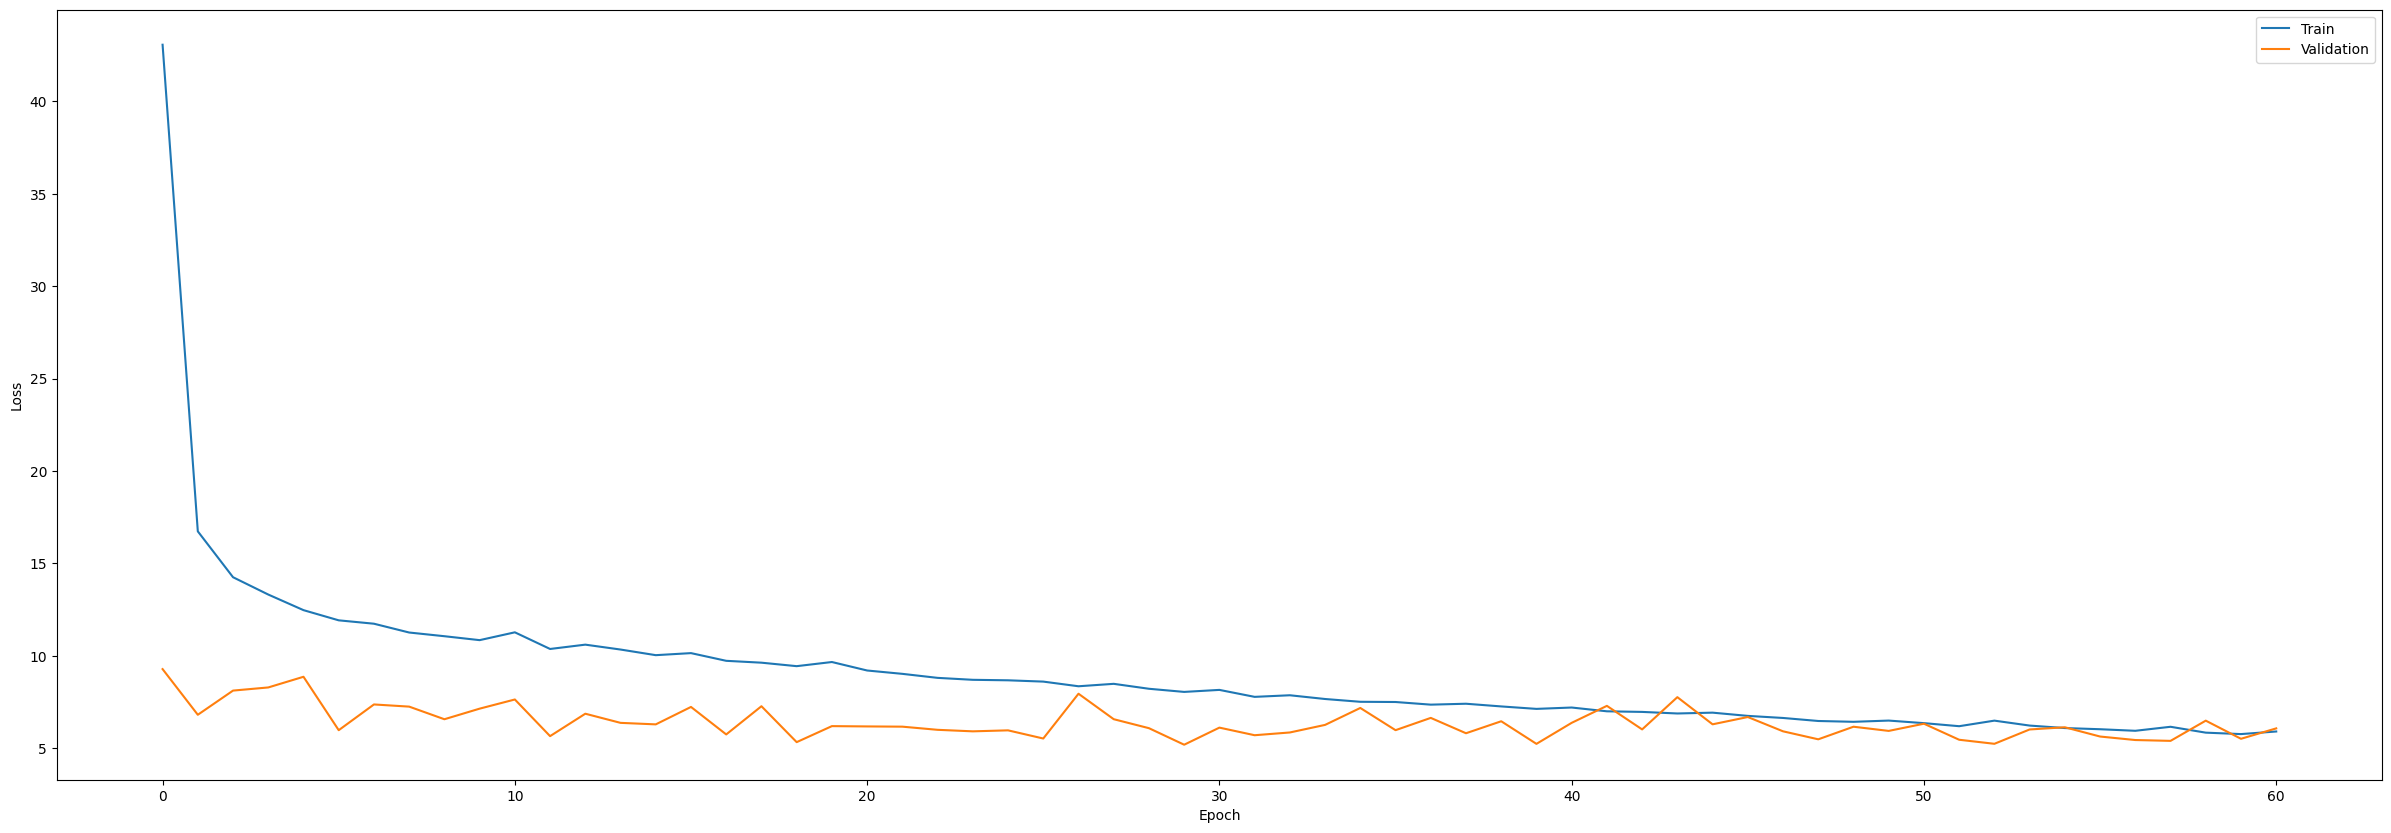

In [39]:
plt.figure(figsize=(30, 10))
plt.plot(model_results['loss'], label='Train')
plt.plot(model_results['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [35]:
model.eval()
with torch.inference_mode():
  test_preds_scaled = model(torch.tensor(X_test_3D, dtype=torch.float32).to(device))
test_preds_scaled = test_preds_scaled.to('cpu').squeeze().numpy()
test_preds_scaled.shape

(8233, 24)

In [36]:
test_preds_df_scaled = pd.DataFrame(test_preds_scaled, columns=np.arange(1, STEPS_FORWARD+1), index=y_test_df.index)

In [37]:
test_preds_df = pd.DataFrame(columns=np.arange(1, STEPS_FORWARD+1), index=test_preds_df_scaled.index)
for i, col in enumerate(test_preds_df_scaled.columns):
  test_preds_df[i+1] = scaler.data_min_[TARGET_POS] + test_preds_df_scaled[col].to_numpy() * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])

real_df = pd.DataFrame(columns=np.arange(1, STEPS_FORWARD+1), index=test_preds_df.index)
for i, col in enumerate(y_test_df.columns):
  real_df[i+1] = scaler.data_min_[TARGET_POS] + y_test_df[col].to_numpy() * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])

In [38]:
mape_list = list()
step_results_dict = {}
for step in range(1, STEPS_FORWARD + 1):
  step_index = real_df.index + pd.to_timedelta(SKIP_STEPS_FORWARD + step, 'h')
  step_results_df = pd.DataFrame(
      {
          "real": real_df.loc[:, step].to_numpy(),
          "predictions": test_preds_df.loc[:, step].to_numpy()
      },
      index=step_index
  )
  step_results_df['abs_error'] = abs(step_results_df['real'] - step_results_df['predictions'])
  step_results_df['ape'] = np.where(step_results_df['real'] == 0, np.NaN, 100 * step_results_df['abs_error']/step_results_df['real'])
  step_mape = step_results_df['ape'].mean()
  mape_list.append(step_mape)
  print(f"Step {step} -> MAPE = {step_mape}")

  step_results_dict[step] = step_results_df
mape = np.array(mape_list).mean()
print(f"\nMAPE = {mape}")

Step 1 -> MAPE = 8.164709016084096
Step 2 -> MAPE = 8.232884507396461
Step 3 -> MAPE = 8.227938769330034
Step 4 -> MAPE = 7.767422770715128
Step 5 -> MAPE = 7.523490122998442
Step 6 -> MAPE = 7.410911384584059
Step 7 -> MAPE = 7.79076389944624
Step 8 -> MAPE = 8.312328264183568
Step 9 -> MAPE = 7.841767469656544
Step 10 -> MAPE = 7.715341785212328
Step 11 -> MAPE = 7.908458003227057
Step 12 -> MAPE = 8.156916252620618
Step 13 -> MAPE = 7.676098586692709
Step 14 -> MAPE = 8.319209612907729
Step 15 -> MAPE = 8.63139755519673
Step 16 -> MAPE = 8.24028689191216
Step 17 -> MAPE = 7.986531289207645
Step 18 -> MAPE = 7.219002447712764
Step 19 -> MAPE = 7.201962119062285
Step 20 -> MAPE = 7.196571523077178
Step 21 -> MAPE = 7.406536504283289
Step 22 -> MAPE = 7.46434197683219
Step 23 -> MAPE = 7.379868476757582
Step 24 -> MAPE = 7.925117908869864

MAPE = 7.8208273807486135
